# Unsupervised Feature Alignment with Soft DTW Loss

In this exercise we will use a library to get a distance function on time-series and use that as loss. You will get to know dynamic time warping which can be used to measure the distance between sequences. You will also use a certain network architecture called Siamese network which can be used supervised but also unsupervised to map positive and negative examples into a feature space and then minimize the distance of their feature representation. In this notebook you will use both together to train a network unsupervised to create a representation where similar activities are close to each other and finally use a kNN classifier to calculate the performance on a downstream classification task. 

### Exercise Overview

In this exercise, you will:
1. Use a library for **SOFT** Dynamic Time Warping (DTW) to compute time-series similarity. (Soft is very important as normal DTW is not differentiable). Please look into pysdtw (Available with pip or https://github.com/toinsson/pysdtw) which is a pytorch based Cuda-ready version.
2. Implement a custom PyTorch Dataset for generating sequence pairs dynamically.
3. Train a Siamese network using Soft DTW as the loss function.
4. Evaluate the learned representations using a k-Nearest Neighbors (kNN) classifier.
5. Finetune using a single linear layer
6. Visualize and analyze the results.
7. (Bonus) Show the strength between the correlation between the DTW-distance of the input and the feature representation.

### Dataset
We will use the UCI Human Activity Recognition (HAR) dataset, which contains time-series data from smartphone accelerometers and gyroscopes.

**Important**: At the end you should write a report of adequate size, which will probably mean at least half a page. In the report you should describe how you approached the task. You should describe:
- Encountered difficulties (due to the method, e.g. "not enough training samples to converge", not technical like "I could not install a package over pip")
- Steps taken to alleviate difficulties
- General description of what you did, explain how you understood the task and what you did to solve it in general language, no code.
- Potential limitations of your approach, what could be issues, how could this be hard on different data or with slightly different conditions
- If you have an idea how this could be extended in an interesting way, describe it.

# Some explanations

## Dynamic Time Warping
Dynamic Time Warping (DTW) is an algorithm used to measure the similarity between two time series, even if they are out of sync in terms of speed or timing. Unlike traditional methods that align data point by point, DTW allows for non-linear alignment by "warping" the time axis. The idea is to find the optimal match between two sequences by stretching or compressing them along the time axis, minimizing the total distance between corresponding points. DTW does this by computing a cost matrix, where each entry represents the cost of aligning a point from one series with a point from the other. The path with the lowest cumulative cost is the optimal alignment.

As a distance function, DTW is useful for comparing time series that might have different lengths or varying speeds. For example, DTW can be applied to applications such as speech recognition, where two spoken phrases might be of different lengths or spoken at different speeds, but still convey the same meaning. By calculating the DTW distance, we can measure how similar two time series are, regardless of time shifts or distortions. 

Excellent introduction: https://www.youtube.com/watch?v=ERKDHZyZDwA

## Siamese Networks
Siamese Networks are a type of neural network architecture designed for comparing two inputs and measuring their similarity. Instead of directly predicting a single label for an input, Siamese Networks take in two input data points, pass them through identical networks (hence "siamese"), and compare the outputs. The network can be trained by stating if the two inputs are equal or uneqal. If they map into a feature space instead of immediately into an output label space, the distance in the feature space can be used in the loss function which is the task here.

In the context of this unsupervised representation learning, Siamese Networks can be used to learn meaningful features from unlabeled data. A popular technique related to this is *MoCo* (Momentum Contrast), which uses Siamese-like networks for contrastive learning. In MoCo, two different views (augmented versions) of the same data point are passed through two identical networks. One network is updated using the current model, while the other follows a momentum-based update rule. The networks are trained to bring the representations of similar views (positive pairs) closer together, while pushing the representations of dissimilar views (negative pairs) apart. This approach allows the model to learn useful representations for later fine-tuning on a classification task without needing explicit labels, relying instead on the assumption that augmented views of the same instance should be similar in the learned feature space.

In this exercise the Siamese network should be used to learn to structure the feature space, guided by the similarity calculation of the DTW. After it should be evaluated how well that method performs for classification. The comment about MoCo is only for information about this close topic, it is not necessary to use it at all.

## Part 1: Data Preparation

Load the UCI HAR dataset and implement a custom `Dataset` class to generate pairs dynamically.

In [2]:
import urllib.request

def unzip(filename, dest_path = None):
    # unzips a zip file in the folder of the notebook to the notebook
    with ZipFile(filename, 'r') as zObject: 
        # Extracting all the members of the zip  
        # into a specific location. a
        if dest_path is None:
            zObject.extractall(path=os.getcwd())
        else:
            zObject.extractall(path=dest_path)

import os
def download(url, filename):
    # download with check if file exists already
    if os.path.isfile(filename):
        return
    urllib.request.urlretrieve(url,filename)

from zipfile import ZipFile

# Un-comment lines below only if executing on Google-COLAB
# ![[ -f UCI_HAR.zip ]] || wget --no-check-certificate https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/Practical_sequentialData/UCI_HAR.zip
# ![[ -f "UCI_HAR" ]] || unzip UCI_HAR.zip

download('https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/Practical_sequentialData/UCI_HAR.zip','UCI_HAR.zip')

unzip('UCI_HAR.zip')

In [3]:
# Import Necessary packages
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn as sk
import sys
print('Your python version: {}'.format(sys.version_info.major))



#Path to the dataset folder
filepath='./UCI_HAR/'

groups=['train','test']

for group in groups:
    prefix=filepath+group+'/InertialSignals/'
    
    
    filenames = list()
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    loaded = []
    for name in filenames:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        #Concatenation of all data concerning the two 3D raw features (body acceleration and angular velocity)
        loaded.append(data)

    #Name of the last 3D raw feature
    filenames_rest = ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']

    #First add the two previous 3D raw features
    loaded_all = []
    loaded_all += loaded

    #Then add the last 3D raw feature
    for name in filenames_rest:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        #Concatenation of all data concerning all 3D raw features (body acceleration, angular velocity and total acceleration)
        loaded_all.append(data)

    # Stack group so that features are the 3rd dimension --> (samples, time steps, features)
    loaded = np.dstack(loaded)
    loaded_all = np.dstack(loaded_all)

    if group == 'train':
        #Training set for two 3D raw features
        tx_train = loaded
        #Training set for all 3D raw features
        tx_train_all = loaded_all
    if group =='test':
        #Testing set for two 3D raw features
        tx_test = loaded
        #Testing set for all 3D raw features
        tx_test_all = loaded_all

nbTimeseries = tx_train_all[0].shape[1]
lengthTimeseries = tx_train_all[0].shape[0]
print("Shape of examples:",tx_train_all[0].shape," (i.e. ",nbTimeseries," timeseries of length=",lengthTimeseries,")")

print("Training set shape:",tx_train_all.shape)
print("Test set shape:",tx_test_all.shape)

# Load labels
y_train = []
y_test = []
y_train_file = open(filepath+'train/y_train.txt', 'r')
y_test_file = open(filepath+'test/y_test.txt', 'r')
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
target_train = np.array(y_train) - 1
target_test = np.array(y_test) - 1

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

nbClasses = len(labels)
print("Number of classes =", nbClasses)
print("Activity classes (target values)",labels)

# Shuffle (because data is initially somewhat organized by class)
tx_train_all, target_train = sk.utils.shuffle(tx_train_all, target_train, random_state=0)
tx_test_all, target_test = sk.utils.shuffle(tx_test_all, target_test, random_state=0)

Your python version: 3
Shape of examples: (128, 9)  (i.e.  9  timeseries of length= 128 )
Training set shape: (7352, 128, 9)
Test set shape: (2947, 128, 9)
Number of classes = 6
Activity classes (target values) {1: 'WALKING', 2: 'WALKING UPSTAIRS', 3: 'WALKING DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import random

# Load the UCI HAR dataset (adjust file paths as needed)
# X_train = pd.read_csv('./UCI_HAR/train/X_train.txt', delim_whitespace=True, header=None)
# y_train = pd.read_csv('./UCI_HAR/train/y_train.txt', header=None).values.ravel()
# X_test = pd.read_csv('./UCI_HAR/test/X_test.txt', delim_whitespace=True, header=None)
# y_test = pd.read_csv('./UCI_HAR/test/y_test.txt', header=None).values.ravel()

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Define a custom Dataset for Siamese Network
class SiameseDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Define the logic for selecting pairs of sequences
        pair_label = round(random.randint(0, 1))

        if pair_label:
            # Positive pair (same class), label = 1
            idx2 = random.randint(0, len(self.data) - 1)
            while self.labels[idx2] != self.labels[idx]:
                idx2 = random.randint(0, len(self.data) - 1)

        else:
            # Negative pair (different class), label = 0
            idx2 = random.randint(0, len(self.data) - 1)
            while self.labels[idx2] == self.labels[idx]:
                idx2 = random.randint(0, len(self.data) - 1)

        seq1 = self.data[idx][:, :6]
        seq2 = self.data[idx2][:, :6]
        seq1 = torch.tensor(seq1, dtype=torch.float32, requires_grad=True)
        seq2 = torch.tensor(seq2, dtype=torch.float32, requires_grad=True)
        label = torch.tensor([pair_label], dtype=torch.float32, requires_grad=True)
        return seq1, seq2, pair_label

# Create train and test datasets using the custom Dataset class
train_dataset = SiameseDataset(tx_train_all, target_train)
test_dataset = SiameseDataset(tx_test_all, target_test)

In [5]:
tx_train_all.shape

(7352, 128, 9)

In [12]:
target_train.shape

(7352,)

7352 times series of 128 timesteps of 9 features.

In [6]:
len(target_train)

7352

In [7]:
train_dataset[0][0].shape

torch.Size([128, 6])

In [11]:
train_dataset[0][2]

1

## Part 2: Using a DTW Library

Use a library to compute the Dynamic Time Warping (DTW) distance between sequences. Implement a differentiable Soft DTW function to calculate this distance.

In [ ]:
# Install and use a DTW library like pysdtw
import pysdtw

def dtw_distance(seq1, seq2):
    # Compute the DTW distance between two sequences
    # optionally choose a pairwise distance function
    # seq1 of shape (128, 9), seq2 of shape (128, 9)
    fun = pysdtw.distance.pairwise_l2_squared

    # create the SoftDTW distance function
    sdtw = pysdtw.SoftDTW(gamma=0.001, dist_func=fun, use_cuda=False)

    # soft-DTW discrepancy, approaches DTW as gamma -> 0
    # compare each acceleration and gyro data
    # accx = sdtw(seq1[:, 0], seq2[:, 0])
    # accy = sdtw(seq1[:, 1], seq2[:, 1])
    # accz = sdtw(seq1[:, 2], seq2[:, 2])
    # gyrox = sdtw(seq1[:, 3], seq2[:, 3])
    # gyroy = sdtw(seq1[:, 4], seq2[:, 4])
    # gyroz = sdtw(seq1[:, 5], seq2[:, 5])
    # res = (accx + accy + accz) / 3
    res = sdtw(seq1, seq2)
    loss = res.mean()
    return loss

# Test the DTW function with example sequences
d_0 = []
d_1 = []
n = 50
for i in range(n):
    seq1, seq2, label = train_dataset[0]
    # print(seq1.shape)
    seq1 = seq1.unsqueeze(0)
    seq2 = seq2.unsqueeze(0)
    distance = dtw_distance(seq1, seq2)
    if label == 0:
        d_0.append(distance.item())
    else:
        d_1.append(distance.item())
    print(f"DTW distance: {distance}, Label: {label}")


print(f"\n\nMean DTW distance for label 0: {np.mean(d_0):.3f}")
print(f"Mean DTW distance for label 1: {np.mean(d_1):.3f}")

DTW distance: 0.10518583655357361, Label: 1
DTW distance: -0.07250571995973587, Label: 1
DTW distance: 100.6078872680664, Label: 0
DTW distance: 149.0078582763672, Label: 0
DTW distance: 85.1321029663086, Label: 0
DTW distance: -0.07046439498662949, Label: 1
DTW distance: 0.27484792470932007, Label: 1
DTW distance: 0.14723347127437592, Label: 1
DTW distance: -0.09039749950170517, Label: 1
DTW distance: 0.09962930530309677, Label: 1
DTW distance: 176.7351531982422, Label: 0
DTW distance: -0.08532507717609406, Label: 1
DTW distance: 0.5710245370864868, Label: 0
DTW distance: 0.6494342684745789, Label: 1
DTW distance: 135.85935974121094, Label: 0
DTW distance: 95.50320434570312, Label: 0
DTW distance: 50.34520721435547, Label: 0
DTW distance: -0.10988287627696991, Label: 1
DTW distance: 6.794946193695068, Label: 1
DTW distance: 0.05119739845395088, Label: 1
DTW distance: -0.061859894543886185, Label: 1
DTW distance: -0.0765310749411583, Label: 1
DTW distance: 6.801090240478516, Label: 1
D

## Part 3: Train a Siamese Network

Define and train a Siamese network in PyTorch using the Soft DTW loss function. Implement the network structure and training logic.

In [ ]:
# Define a Siamese Network class
class SiameseNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SiameseNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize the network layers
        # input_size=(128 x 6), we want to reduce it to hidden_size=128
        self.first_layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU()
        ) 
        # output (128x128) at this point
        self.last_layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_size * 128, hidden_size),
            torch.nn.ReLU()
        )   

    def forward_one(self, x):
        # Forward pass logic for one branch
        x = self.first_layers(x)
        x = x.view(-1, self.hidden_size * 128)
        x = self.last_layers(x)
        return x

    def forward(self, input1, input2):
        # Logic for processing both branches
        # print("shape input1", input1.shape, "shape input2", input2.shape)
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        # print("shape output1", output1.shape, "shape output2", output2.shape)
        return output1, output2
    
        # return output1, output2

# Train the network with the defined loss function (dtw_distance) and optimizer
def train_network(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (seq1, seq2, label) in enumerate(train_loader):
            optimizer.zero_grad()
            out1, out2 = model(seq1, seq2)
            # print("shape label", label.shape)
            loss = criterion(out1, out2, label.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss}")


# Initialize the Siamese Network model
input_size = train_dataset[0][0].shape[1]
hidden_size = 128 # features space dimension
model = SiameseNetwork(input_size, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

criterion = ContrastiveLoss(margin=1.5)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train the Siamese Network
train_network(model, train_loader, criterion, optimizer, num_epochs=50)

Epoch 1, Loss: 89.3850467801094
Epoch 2, Loss: 77.02008980512619
Epoch 3, Loss: 73.94363594055176
Epoch 4, Loss: 72.61676493287086
Epoch 5, Loss: 71.40458625555038
Epoch 6, Loss: 70.63721430301666
Epoch 7, Loss: 69.87571269273758
Epoch 8, Loss: 69.90037077665329
Epoch 9, Loss: 69.26155757904053
Epoch 10, Loss: 69.0110114812851
Epoch 11, Loss: 68.81434720754623
Epoch 12, Loss: 69.5323137640953
Epoch 13, Loss: 68.74084475636482
Epoch 14, Loss: 68.21156376600266
Epoch 15, Loss: 68.10728198289871
Epoch 16, Loss: 67.89023244380951
Epoch 17, Loss: 67.5528809428215
Epoch 18, Loss: 67.67386263608932
Epoch 19, Loss: 67.8295396566391
Epoch 20, Loss: 68.12090235948563
Epoch 21, Loss: 67.88143455982208
Epoch 22, Loss: 67.98032265901566
Epoch 23, Loss: 67.28477597236633
Epoch 24, Loss: 67.54151725769043
Epoch 25, Loss: 67.17399424314499
Epoch 26, Loss: 67.27398705482483
Epoch 27, Loss: 67.27323567867279
Epoch 28, Loss: 67.10078871250153
Epoch 29, Loss: 67.3071591258049
Epoch 30, Loss: 68.0413318872

## Part 4: Evaluate Representations with kNN

Use the trained network to extract embeddings and evaluate their quality using a kNN classifier.

In [31]:
tx_train_all.shape

(7352, 128, 9)

In [35]:
train_features = model.forward_one(torch.tensor(tx_train_all[:,:,0:6], dtype=torch.float32))
test_features = model.forward_one(torch.tensor(tx_test_all[:,:,0:6], dtype=torch.float32))
train_features.shape

torch.Size([7352, 128])

Accuracy: 0.37699355276552426
Confusion Matrix:
[[299  56  44  52  13  32]
 [155 143  47  46  22  58]
 [102  86  86  55  30  61]
 [ 25  13  14 233  94 112]
 [ 41  29  14 215 120 113]
 [ 26  25  15 186  55 230]]


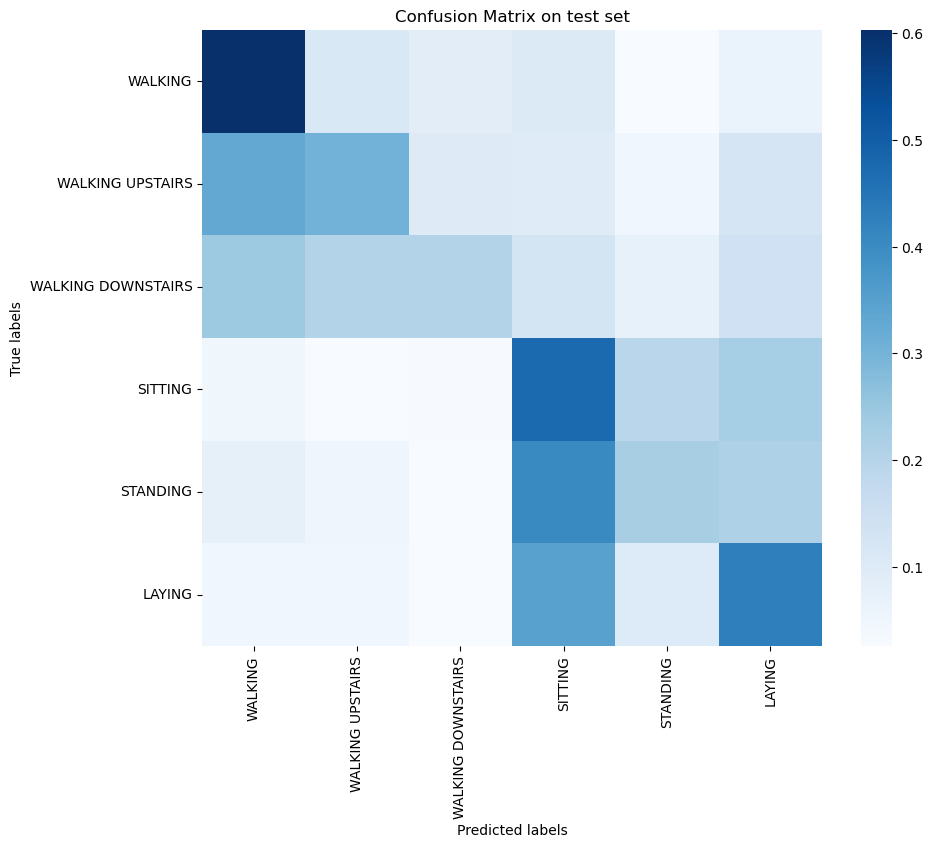

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

knn = KNeighborsClassifier(
    n_neighbors=3
)
# evaluate on the test set
# for a point of the test set, retrieve the nearest neighbors in the train set
# and assign the label of the majority of the neighbors
knn.fit(train_features.detach().numpy(), target_train)
y_pred = knn.predict(test_features.detach().numpy())
accuracy = accuracy_score(target_test, y_pred)
conf_matrix = confusion_matrix(target_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(target_test, y_pred, normalize='true')
sns.heatmap(
    conf_matrix, fmt='g', cmap='Blues',
    xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set')
plt.show()

The results are pretty good. We can see that some classes are very well separated, while others are more mixed. For example, standing is often mistaken for sitting, and walking upstairs is often mistaken for walking. This is expected, as these activities are similar in nature and can be hard to distinguish based on accelerometer data alone.

## Part 5: Fine-Tuning with a Linear Layer

Freeze the Siamese network and add a linear layer on top. Fine-tune the linear layer and re-evaluate the model.

In [115]:
# Freeze the Siamese network
for param in model.parameters():
    param.requires_grad = False

# Add and train a few linear layers for fine-tuning
fc = torch.nn.Sequential(
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 6),
    torch.nn.Softmax(dim=1)
)

def fine_tune(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for i, (seq, label) in enumerate(train_loader):
            optimizer.zero_grad()
            out = model.forward_one(seq)
            out = fc(out)
            loss = criterion(out, label.long())
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    return model

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)

# Create a DataLoader
class Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(seq, dtype=torch.float32, requires_grad=True), torch.tensor(label, dtype=torch.float32)

train_dataset = Dataset(tx_train_all[:,:,0:6], target_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = Dataset(tx_test_all[:,:,0:6], target_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = fine_tune(model, train_loader, criterion, optimizer, num_epochs=50)

Epoch 1, Loss: 1.7863616943359375
Epoch 2, Loss: 1.7720476388931274
Epoch 3, Loss: 1.7559512853622437
Epoch 4, Loss: 1.7726258039474487
Epoch 5, Loss: 1.7150415182113647
Epoch 6, Loss: 1.7470003366470337
Epoch 7, Loss: 1.745849370956421
Epoch 8, Loss: 1.7527062892913818
Epoch 9, Loss: 1.7420547008514404
Epoch 10, Loss: 1.7084801197052002
Epoch 11, Loss: 1.70526123046875
Epoch 12, Loss: 1.677638053894043
Epoch 13, Loss: 1.6942251920700073
Epoch 14, Loss: 1.6378448009490967
Epoch 15, Loss: 1.6654895544052124
Epoch 16, Loss: 1.638565182685852
Epoch 17, Loss: 1.6497652530670166
Epoch 18, Loss: 1.6553781032562256
Epoch 19, Loss: 1.647560715675354
Epoch 20, Loss: 1.6459691524505615
Epoch 21, Loss: 1.6600991487503052
Epoch 22, Loss: 1.6218464374542236
Epoch 23, Loss: 1.6477874517440796
Epoch 24, Loss: 1.6645190715789795
Epoch 25, Loss: 1.6657676696777344
Epoch 26, Loss: 1.6293851137161255
Epoch 27, Loss: 1.6699787378311157
Epoch 28, Loss: 1.6800481081008911
Epoch 29, Loss: 1.597139596939087
E

Accuracy: 0.4197488971835765
Confusion Matrix:
[[366  49  38   7  28   8]
 [132 154  84  18  42  41]
 [ 91  92 137  10  35  55]
 [ 35  12  16 164 144 120]
 [ 50  30  37  98 185 132]
 [ 30  28  25 120 103 231]]


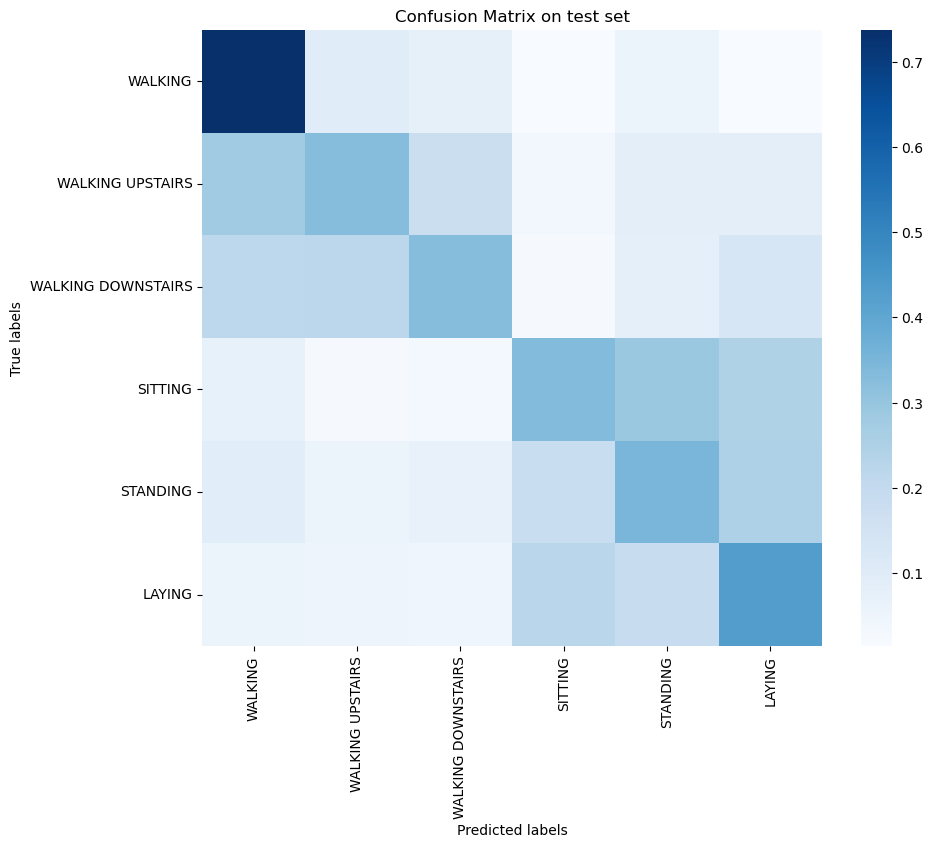

In [116]:
# Evaluate the fine-tuned model
def evaluate(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    for i, (seq, label) in enumerate(test_loader):
        out = model.forward_one(seq)
        out = fc(out)
        pred = torch.argmax(out, dim=1)
        y_pred.extend(pred.detach().numpy())
        y_true.extend(label.detach().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate(model, test_loader)
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(
    conf_matrix, fmt='g', cmap='Blues',
    xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set')
plt.show()